In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(42)

True
cuda


trajectory (1001, 12, 2)
N_STEPS = 1001
NUM_PARTICLES = 12
N_FEATURES = 24


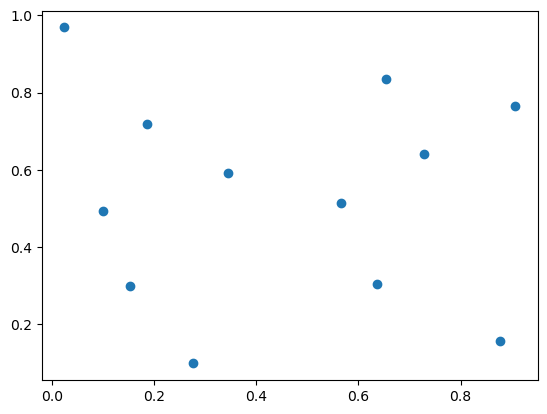

In [2]:
# Load data
loaded_trajectory_pos = np.load('trajectory_pos.npy', allow_pickle=True)
print("trajectory",loaded_trajectory_pos.shape )
N_STEPS = len(loaded_trajectory_pos)
NUM_PARTICLES = loaded_trajectory_pos[0].shape[0]
LX = 5. # BOX WIDTH
LY = 5.  # BOX HEIGHT
CUT_OFF = 2.5/LX
DEG_FREED = 2 # degrees of freedom, here x and y coordinates
N_FEATURES = NUM_PARTICLES * DEG_FREED
print('N_STEPS =', N_STEPS)
print('NUM_PARTICLES =', NUM_PARTICLES)
print('N_FEATURES =', N_FEATURES)

# Normalize x positions
normalized_x_positions = loaded_trajectory_pos[:, :, 0] / LX
# Normalize y positions
normalized_y_positions = loaded_trajectory_pos[:, :, 1] / LY
# Combine normalized x and y positions back into a single array
normalized_positions = np.stack((normalized_x_positions, normalized_y_positions), axis=-1)
# Feature matrix for timestep
timestep=999
feature_matrix = normalized_positions[timestep]
plt.scatter(feature_matrix[:,0], feature_matrix[:,1], marker='o')


In [3]:
def calculate_adjacency_matrix(positions, cutoff):
    """Calculate adjacency matrix based on a cutoff distance."""
    num_particles = positions.shape[0]
    # Compute pairwise distance matrix
    dist_matrix = np.sqrt(np.sum((positions[:, np.newaxis, :] - positions[np.newaxis, :, :]) ** 2, axis=-1))
    # Create adjacency matrix: 1 if distance is less than cutoff, 0 otherwise
    adjacency_matrix = (dist_matrix < cutoff).astype(int)
    # Remove self-loops
    np.fill_diagonal(adjacency_matrix, 0)
    return adjacency_matrix

In [4]:
timestep = 999
# Calculate the adjacency matrix for the timestep
adjacency_matrix = torch.tensor(calculate_adjacency_matrix(normalized_positions[timestep], CUT_OFF))
# Convert the adjacency matrix to edge_index format
edge_index = torch.tensor(np.array(adjacency_matrix.nonzero()), dtype=torch.long)
print(adjacency_matrix.shape)
print(adjacency_matrix)
print(edge_index.shape)
print(edge_index)

torch.Size([12, 12])
tensor([[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0]], dtype=torch.int32)
torch.Size([64, 2])
tensor([[ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 1,  4],
        [ 1,  5],
        [ 1,  6],
        [ 1,  7],
        [ 1,  8],
        [ 1,  9],
        [ 2,  7],
        [ 2, 10],
        [ 2, 11],
        [ 3,  7],
        [ 3,  8],
        [ 4,  0],
        [ 4,  1],
        [ 4,  5],
        [ 4,  6],
        [ 4,  7],
        [ 4,  8],
        [ 4,  9],
        [

PyTorch Geometric requires the data to be in a specific format, encapsulated by a Data object that contains information about the graph such as the node features, edge index, and potentially edge features or other graph-level attributes.

In [5]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

def create_dataset(normalized_positions, cutoff):
    dataset = []
    for i in range(len(normalized_positions) - 1):
        x = torch.tensor(normalized_positions[i], dtype=torch.float)
        y = torch.tensor(normalized_positions[i + 1], dtype=torch.float)  # Targets are the next timestep positions
        adj_matrix_nonzero = np.array(calculate_adjacency_matrix(normalized_positions[i], cutoff).nonzero())
        edge_index = torch.tensor(adj_matrix_nonzero, dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y)  # Include y here
        dataset.append(data)
    return dataset

# Dataset creation
cutoff = CUT_OFF  
dataset = create_dataset(normalized_positions, cutoff)

# Define the size of the training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Perform a random split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

PyTorch Geometric provides several types of GNN layers: GCN (Graph Convolutional Network) layers, GAT (Graph Attention Network) layers, etc. Here's a simple example using GCN layers:

In [6]:
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GCN, self).__init__()
        N_HIDDEN = 24
        self.layers = nn.ModuleList()
        self.conv0 = GCNConv(num_node_features, N_HIDDEN)
        for _ in range(3):
            self.layers.append(GCNConv(N_HIDDEN, N_HIDDEN))
        self.convF = GCNConv(N_HIDDEN, 2)  # 2 output features for x, y positions

    def forward(self, x, edge_index):
        x = F.relu(self.conv0(x, edge_index))
        for layer in self.layers:
            x = F.relu(layer(x, edge_index))
        x = self.convF(x, edge_index)
        return x

In [7]:
model = GCN(num_node_features=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [8]:
training_losses = []
validation_losses = []

for epoch in range(1001):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index)
        loss = criterion(output, data.y)  # 'y' is the target tensor
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # Append loss
    training_losses.append(total_loss / len(train_loader))
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            output = model(data.x, data.edge_index)
            val_loss += criterion(output, data.y).item()
    #Append loss
    validation_losses.append(val_loss/ len(val_loader))    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}: Loss {total_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}')

Epoch 0: Loss 0.10275706708431244, Val Loss: 0.07397327359233584
Epoch 100: Loss 0.010950728207826615, Val Loss: 0.01139063827161278
Epoch 200: Loss 0.007419359162449837, Val Loss: 0.00828384208892073
Epoch 300: Loss 0.0071465024352073666, Val Loss: 0.0078444500187678
Epoch 400: Loss 0.006706895474344492, Val Loss: 0.006667364056089095
Epoch 500: Loss 0.0057157595455646516, Val Loss: 0.006455431492733104
Epoch 600: Loss 0.005683810859918595, Val Loss: 0.00668439335588898
Epoch 700: Loss 0.004963551741093397, Val Loss: 0.0052593971070434365
Epoch 800: Loss 0.00526213907636702, Val Loss: 0.005705180378364665
Epoch 900: Loss 0.005039498601108789, Val Loss: 0.0053792404276984075
Epoch 1000: Loss 0.00484624364413321, Val Loss: 0.005251764186791011


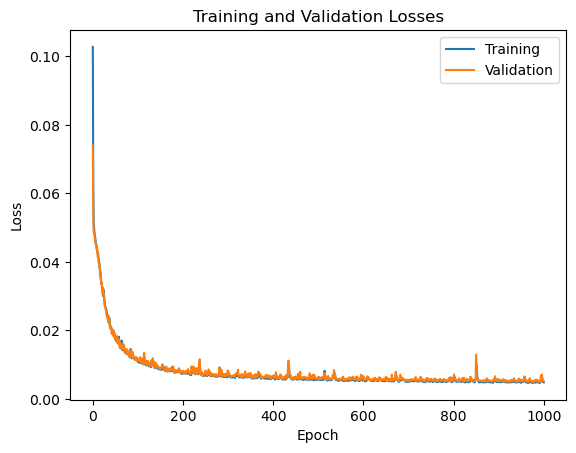

In [9]:
plt.plot(training_losses, label='Training')
plt.plot(validation_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [10]:
model.eval()

input_pos = normalized_positions[0:N_STEPS-1,:,:]
real_pos = normalized_positions[1:N_STEPS,:,:]

predicted_positions_list = []  # List to collect numpy arrays of predicted positions

for previous_time_pos in input_pos:
    previous_time_pos_tensor = torch.tensor(previous_time_pos, dtype=torch.float).to(device)
    adjacency_matrix = calculate_adjacency_matrix(previous_time_pos, CUT_OFF)
    edge_index = torch.tensor(np.array(adjacency_matrix.nonzero()), dtype=torch.long).to(device)
    
    with torch.no_grad():
        predicted_pos = model(previous_time_pos_tensor, edge_index).cpu().detach().numpy()
        predicted_positions_list.append(predicted_pos)

# Convert the list of numpy arrays to a single numpy array
predicted_positions = np.array(predicted_positions_list)

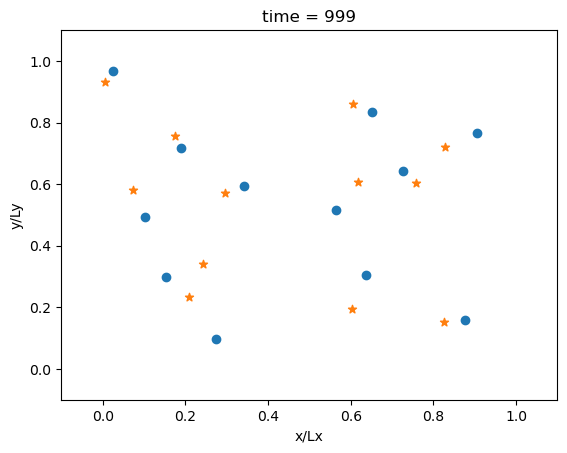

In [11]:
#compare trajectories
time = 999
plt.scatter(real_pos[time,:,0], real_pos[time,:,1], marker='o')
plt.scatter(predicted_positions[time,:,0], predicted_positions[time,:,1], marker='*')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('time = ' + str(time))
plt.xlabel('x/Lx')
plt.ylabel('y/Ly')
plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def make_video(real_y, pred_y, file_name):
    # Update function for the animation
    def update(frame_number, real_y, pred_y, scatter_real, scatter_pred, time_text):
        # Update the data of both scatter plots for the new frame
        scatter_real.set_offsets(real_y[frame_number])
        scatter_pred.set_offsets(pred_y[frame_number])
        # Update the time annotation
        time_text.set_text(f'Time = {frame_number}')
    
    # Set up the figure, the axis, and the plot elements we want to animate
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    
    # Create initial scatter plots and a text annotation
    scatter_real = ax.scatter(real_y[0, :, 0], real_y[0, :, 1], color='blue', marker='o')
    scatter_pred = ax.scatter(pred_y[0, :, 0], pred_y[0, :, 1], color='orange', marker='*')
    time_text = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha='center')
    
    # Create the animation using FuncAnimation
    ani = FuncAnimation(fig, update, frames=len(real_y), fargs=(real_y, pred_y, scatter_real, scatter_pred, time_text), interval=100)
    
    # Save the animation
    ani.save(file_name, writer='ffmpeg')
    
    # Convert the animation to an HTML5 video embedded in the notebook
    html = HTML(ani.to_html5_video())
    
    # Close the figure to prevent it from displaying in the notebook or script output
    plt.close(fig)
    
    # Return the HTML object to display the animation in the notebook
    return html

In [13]:
make_video(real_pos, predicted_positions, file_name = 'predicted_GNN.mp4')

In [24]:
model.eval()

input_pos = torch.tensor(normalized_positions[0], dtype=torch.float).to(device)

fully_predicted_positions = [input_pos.cpu().detach().numpy()]  # Initialize list with the real initial positions

for i in range(1, N_STEPS):
    adjacency_matrix = calculate_adjacency_matrix(fully_predicted_positions[-1], CUT_OFF)  # Use last predicted positions
    edge_index = torch.tensor(np.array(adjacency_matrix.nonzero()), dtype=torch.long).to(device)
    
    with torch.no_grad():
        fully_predicted_pos = model(input_pos, edge_index).cpu().detach().numpy()
        fully_predicted_positions.append(fully_predicted_pos)  # Append the newly predicted positions
        
    # Update input_pos for the next prediction with the newly predicted positions
    input_pos = torch.tensor(fully_predicted_pos, dtype=torch.float).to(device)

# Convert the list of numpy arrays to a single numpy array for easier handling
fully_predicted_positions = np.array(fully_predicted_positions)

In [39]:
print(fully_predicted_positions[20])

[[ 1.4922536e+10 -7.4172708e+09]
 [ 1.4922536e+10 -7.4172708e+09]
 [ 1.4922536e+10 -7.4172708e+09]
 [ 1.4922536e+10 -7.4172708e+09]
 [ 1.4922536e+10 -7.4172708e+09]
 [ 1.4922536e+10 -7.4172708e+09]
 [ 1.4922536e+10 -7.4172708e+09]
 [ 1.4922536e+10 -7.4172708e+09]
 [ 1.4922536e+10 -7.4172708e+09]
 [ 1.4922536e+10 -7.4172708e+09]
 [ 1.4922536e+10 -7.4172708e+09]
 [ 1.4922536e+10 -7.4172708e+09]]


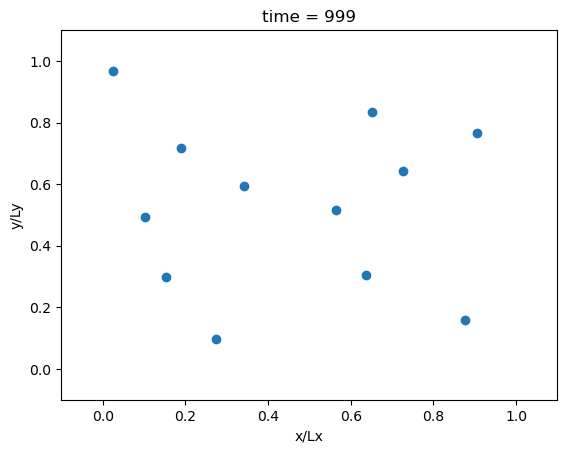

In [23]:
#compare trajectories
time = 999
plt.scatter(real_pos[time,:,0], real_pos[time,:,1], marker='o')
plt.scatter(fully_predicted_positions[time,:,0], fully_predicted_positions[time,:,1], marker='*')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('time = ' + str(time))
plt.xlabel('x/Lx')
plt.ylabel('y/Ly')
plt.show()

In [30]:
# Calculate squared differences for x and y coordinates
d1 = ((real_pos[:, :, 0] - predicted_positions[:, :, 0])**2) + ((real_pos[:, :, 1] - predicted_positions[:, :, 1])**2)
d2 = ((real_pos[0:10, :, 0] - fully_predicted_positions[0:10, :, 0])**2) + ((real_pos[0:10, :, 1] - fully_predicted_positions[0:10, :, 1])**2)
# Sum the errors for all particles at each time step
overall_error_per_timestep1 = np.sum(d1, axis=1)
overall_error_per_timestep2 = np.sum(d2, axis=1)

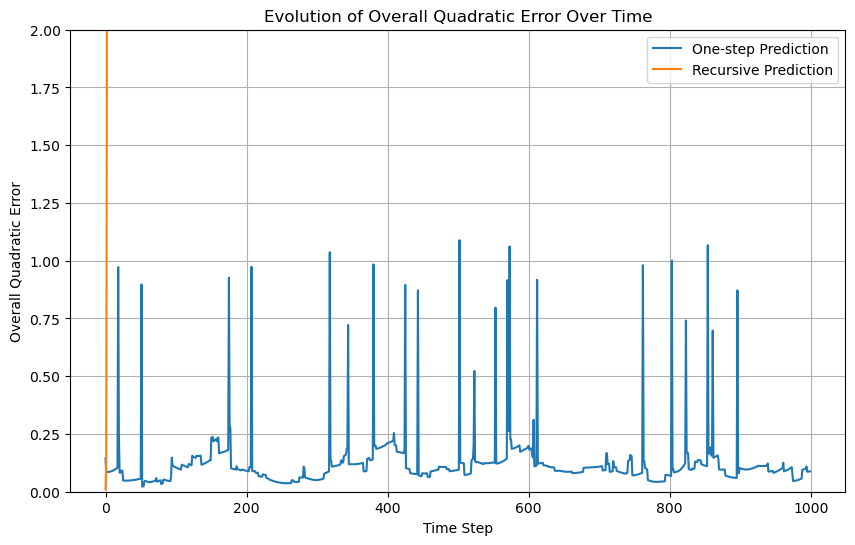

In [35]:
time_steps = np.arange(len(overall_error_per_timestep1))

plt.figure(figsize=(10, 6))
plt.plot(time_steps, overall_error_per_timestep1, label='One-step Prediction')
plt.plot(time_steps[0:10], overall_error_per_timestep2[0:10], label='Recursive Prediction')
plt.xlabel('Time Step')
plt.ylabel('Overall Quadratic Error')
plt.title('Evolution of Overall Quadratic Error Over Time')
plt.ylim([0., 2.])
plt.legend()
plt.grid(True)
plt.show()